In [259]:
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2 as Estimator, SamplerV2 as Sampler
from scipy.optimize import minimize
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Problem 1
## Question
>1) 60 points
>
>For the following graph: Construct a the MaxCut hamiltonian and a QAOA Ansatz circuit with Qiskit.
>What is the width and the depth of the Ansatz? 



## Solution

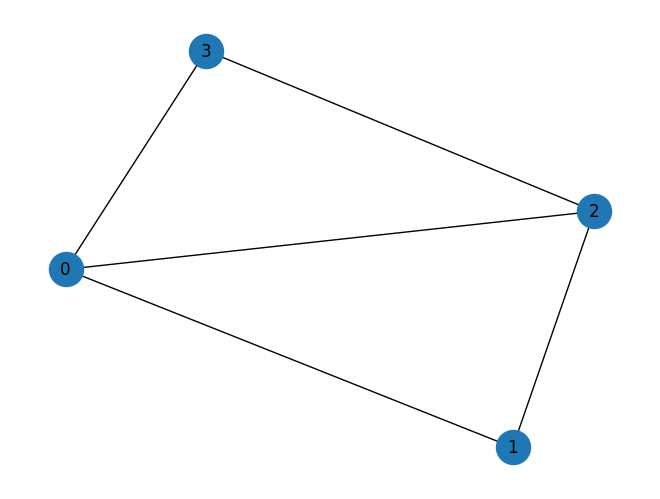

In [260]:
n=4
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (2, 3, 1.0), (0, 3, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [261]:
def build_max_cut_paulis(graph):
    """
    Convert the graph to Pauli list.
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        # Instantiate pauli identity operators
        # Your code goes here: 
        '''construct Hamiltonian'''
        paulis = ['I']*len(graph)
        # Set Z operators for every pair or nodes that are connected via an edge
        # Your code goes here:
        '''Overwrite pauli matrix with a Z matrix wherever there is an edge'''
        paulis[edge[0]],paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])
        # Join in reverse order from list of strings to a single string
        pauli_list.append(("".join(paulis)[::-1], weight))

    hamiltonian = SparsePauliOp.from_list(pauli_list)

    return hamiltonian


hamiltonian = build_max_cut_paulis(graph)

print("Cost Function Hamiltonian:", hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIZZ', 'IZIZ', 'IZZI', 'ZZII', 'ZIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


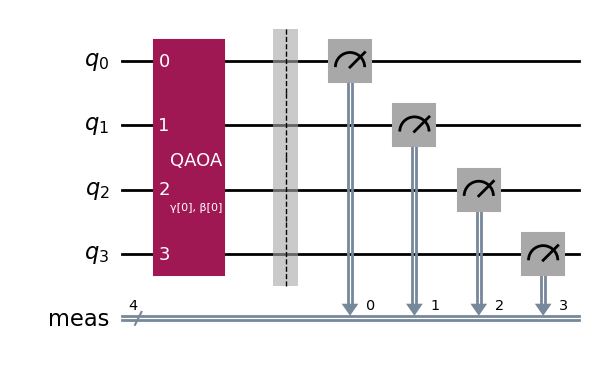

In [262]:
ansatz = QAOAAnsatz(cost_operator=hamiltonian,reps=1)
ansatz.measure_all()
ansatz.draw("mpl")

Decomposing the graph will give us another set of circuit blocks

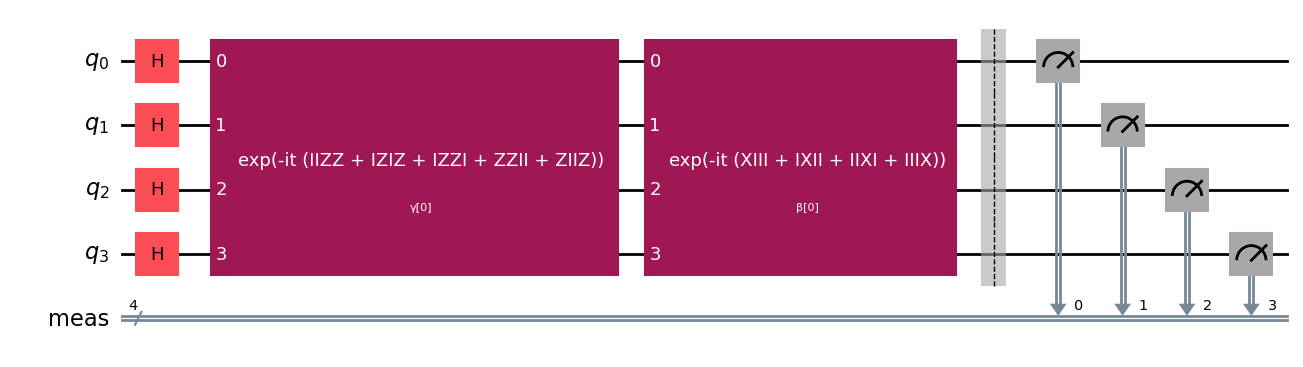

In [263]:
ansatz.decompose().draw("mpl")

So to get the circuit, we must repeat the decomposition.

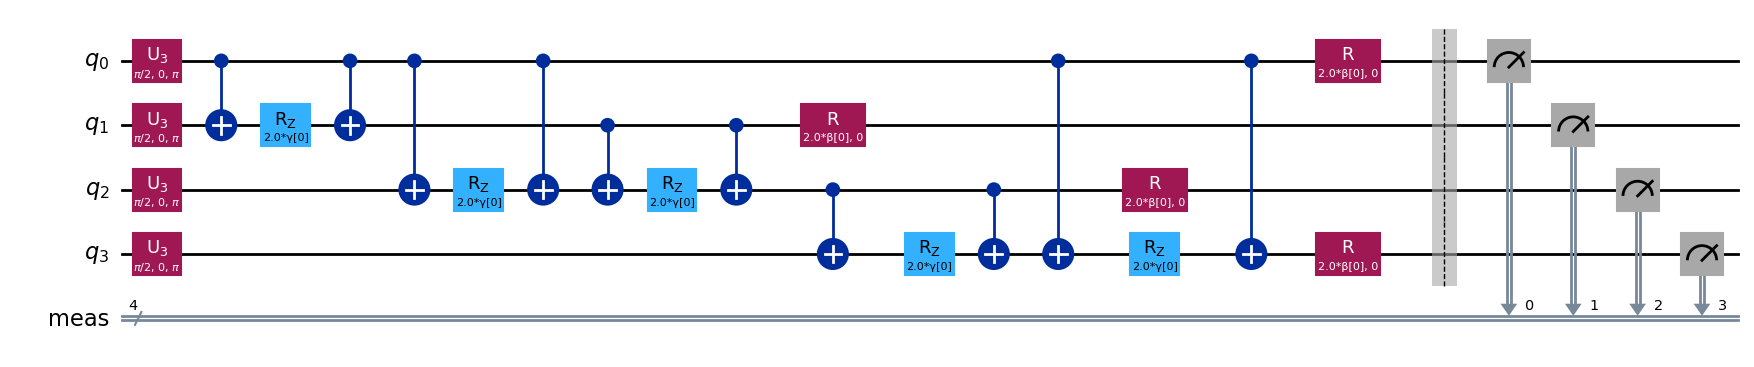

In [264]:
ansatz.decompose(reps=3).draw("mpl")

In [265]:
print(f"Number of parameters in ansatz: {ansatz.num_parameters}")
print(f"Number of qubits in ansatz: {ansatz.num_qubits}")

Number of parameters in ansatz: 2
Number of qubits in ansatz: 4


The depth of a Quantum Circuit is the number of gates along the longest path. The width is the number of qubits **and bits** in the circuit. These can be found with built in functions in qiskit.

In [266]:
print(f"The depth of the ansatz is: {ansatz.depth()}\nand the width is: {ansatz.width()}")

The depth of the ansatz is: 2
and the width is: 8


However, this isn't really the depth of the circuit and is more a measure of how many QAOA rounds are being performed. To find the true depth, we must take the depth of the decomposed circuit which will be larger. *The width will stay the same as you are only expanding the gates, not adding any qubits/bits.*

In [267]:
print(f"The depth of the decomposed ansatz is: {ansatz.decompose(reps=3).depth()}\nwith a width of {ansatz.decompose(reps=3).width()}")

The depth of the decomposed ansatz is: 18
with a width of 8


# Problem 2
## Question
>2) 40 points
>
>Execute the optimisation to find at least two unique solutions to the MaxCut problem described by the graph below. What is the value of the cut size for your solutions?
>
>The cut size is the sum of the edges that are connected by vertices of different groups.

In [268]:

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # Definie the cost function of this QAOA problem using a primitive unified block (pub).
    # Note: the cost is represented by the expecation value of the hamiltonian w.r.t. to the
    # trail wave function (ansatz circuit) and a particular set of prameters.
    
    # Your code goes here:
    pub = (ansatz,hamiltonian,params)
    result = estimator.run([pub]).result()
    cost = result[0].data.evs
    
    objective_func_vals.append(cost)

    return cost

def transpile_problem_hardware(backend,circuit,hamiltonian):
    pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)
    # map the virtual circuit to an ISA on physical qubits
    isa_circuit = pm.run(circuit)
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(isa_circuit.layout)
    return isa_circuit, isa_hamiltonian

In [269]:
sim_backend = AerSimulator()
isa_ansatz, isa_hamiltonian = transpile_problem_hardware(sim_backend,ansatz,hamiltonian)

In [270]:
objective_func_vals = [] 
init_params = np.random.uniform(0,np.pi,size=ansatz.num_parameters)
init_params

with Session(backend=sim_backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(isa_ansatz, isa_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-3,
    )

In [ ]:
optimized_circuit = isa_ansatz.assign_parameters(result.x)

sampler = Sampler(mode=sim_backend)
sampler.options.default_shots = 50000

pub= (optimized_circuit)
job = sampler.run([pub])

counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

two_most_likely_bitstrings = [key for key,value in sorted(
    final_distribution_bin.items(), 
    key=lambda item: item[1], 
    reverse=True)[:2]]
print(f"Two most likely bitstrings: {two_most_likely_bitstrings}")

Two most likely bitstrings: ['1010', '0101']


In [272]:
def plot_result(graph, bitstring):
    '''Define the function to plot the colored graph'''
    bitlist = [int(bit) for bit in bitstring] #Convert the passed bitstring into a list iterable

    plt.figure()
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in bitlist]
    pos, default_axes = rx.spring_layout(graph), plt.axes(frameon=True)
    rx.visualization.mpl_draw(graph, node_color=colors, node_size=100, alpha=0.8, pos=pos)
    plt.title(f"Solution {bitstring}")
    
    #Calculation of the cut size by using the weights of the edges of the graph
    different_color_edge_sum = 0
    for u, v, weight in graph.weighted_edge_list():
        if bitlist[u] != bitlist[v]:  # Check if vertices are of different colors
            different_color_edge_sum += int(weight)  # Add edge weight to the sum

    print(f"Cut size: {different_color_edge_sum}")
    return different_color_edge_sum

Cut size: 4


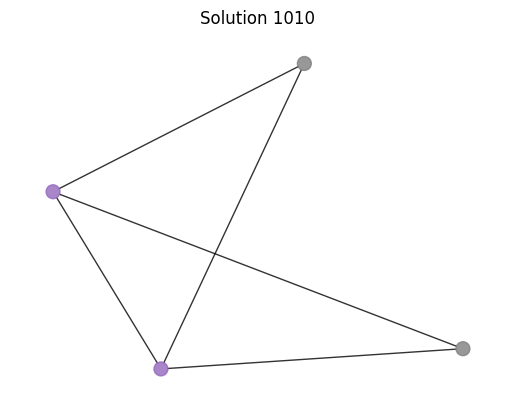

In [273]:
solution_1 = plot_result(graph,two_most_likely_bitstrings[0])

Cut size: 4


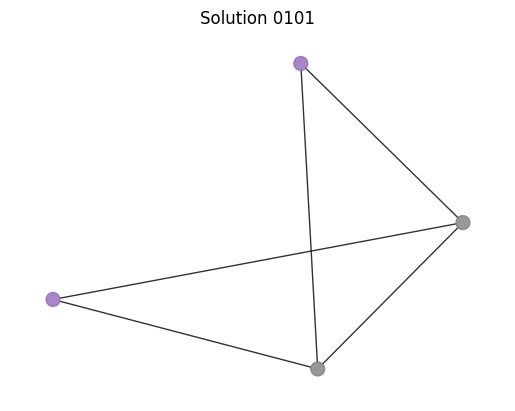

In [274]:
solution_2 = plot_result(graph,two_most_likely_bitstrings[1])